In [4]:
from estimador import *
from filtros import *
from fit_voc import *
from functions import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import math

In [5]:
def fill_with_nan(lst, desired_length):
    # Calculate how many NaN values need to be added
    nan_count = desired_length - len(lst)
    
    # Add NaN values to the list if necessary
    if nan_count > 0:
        lst.extend([math.nan] * nan_count)
    
    return lst

### Obtenemos los datos para parametrizar el modelo de la batería

In [6]:
# Obtenemos los valores de SOH del ground truth
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/uncertainty_characterization/stanford_cell_SOH.csv"
SOH_gt_df = pd.read_csv(path,delimiter=';',)
SOH_gt_df = SOH_gt_df.drop(index=0).reset_index(drop=True)

path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))

SOH_gt_df["files"] = files

# Obtenemos los sicles equivalentes de cada diagnóstico de SOH
EQ_cycles = []
eq_cycles_pt = []
subcycles = [   25,
                50,
                47,
                22,
                1,
                1,
                4,
                29,
                37,
                25,
                25,
                25,
                25,
                25]
SR_0 = 100
SR = 80
acc_subc = 0
for idx,subcycle in enumerate(subcycles):
    eq_cycle = subcycle*(SR/SR_0)
    # eq_cycle = subcycle
    eq_cycles_pt.append(eq_cycle)
    acc_subc += eq_cycle
    EOL_0 = SOH_gt_df["W9"].values[idx]
    eta_0 = EOL_0**(1/acc_subc)
    eq_cycle08 = 1/log_a(0.8,eta_0)
    EQ_cycles.append(eq_cycle08)

SOH_gt_df["eq_cycles08_W9"] = EQ_cycles
w10_axis_val = np.cumsum(eq_cycles_pt)

### Definimos los modelos a usar

In [7]:
param = dict(
    vL=1.35531394,
    v0=4.12017677,
    gamma=0.13286143,
    alpha=0.16945463,
    beta=2.34538224,
    Qmax=4.850,
    Bias_Rint=0.01454392,
    Factor_Rint=0.1879029,
    life_cycles=SOH_gt_df["eq_cycles08_W9"].values[-1],
    adapt_cell=True,
    degradation_percentage=0.8
)

f_new = FiltrosAnidados_new()
f_new.Q_inst = param.get("Qmax")
f_new.fit_batt_model(param)
f_new.modelo_th.fit_inverse()
f_new.voc_thresh = 0.05
f_new.voc_times = 47
f_new.sigma_autonomia = 0.04
f_new.sigma_capacidad = 0.001 * 5
f_new.estim_kwargs = {"sigma_e": 0.00075}

modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [0.7875], '75-0': [1.12525], '100-50': [0.4375], '75-25': [0.6875], '50-0': [1.03125], '100-75': [0.40625], '75-50': [0.297], '62.5-37.5': [0.28125], '50-25': [0.625], '25-0': [1.0]}
KDE es been setted
Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.85,
 'adapt_cell': True,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0],
                      '100-25': [0.7875],
                      '100-50': [0.4375],
                      '100-75': [0.40625],
                      '25-0': [1.0],
                      '50-0': [1.03125],
                      '50-25': [0.625],
                      '62.5-37.5': [0.28125],
                     

### Obtenemos y guardamos los delta de capacidad en toda la data de stanford

In [16]:
dC_w10_standford_values = []

## Iniciamos las configuraciones para el proceso de filtrado
path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
files.remove('C7.csv')
print(files)

# Iterating through all the datasets
for file in files:
    if not file.endswith(".csv"):
        continue  # Skip files that are not CSV

    file_path = os.path.join(path, file)
    columns_to_select = ["step_ind","current","time","exp"]
    df = pd.read_csv(file_path,usecols=columns_to_select)

    for cnt, exp in enumerate(df.exp.unique()):
        print(file, cnt, end="\r")
        df_ = df[df.exp == exp]

        # Iterate over the rows in the filtered DataFrame
        for ind, (c, dt, step,step_) in enumerate(zip(df_.current.values,
                                                    df_.time.values[1:] - df_.time.values[:-1],
                                                    df_.step_ind.values,
                                                    df_.step_ind.values[1:])):
            # hacemos conteo de coulomb
            dc = dt * c
            dC_w10_standford_values.append(dc)

dC_w10_standford_values = np.array(dC_w10_standford_values)
dC_w10_standford_values = dC_w10_standford_values[dC_w10_standford_values != 0]
dC_w10_standford_values = dC_w10_standford_values/36

['C1.csv', 'C2.csv', 'C3.csv', 'C4.csv', 'C5.csv', 'C6.csv', 'C8.csv', 'C9.csv', 'C10.csv', 'C11.csv', 'C12.csv', 'C13.csv', 'C14.csv']


In [17]:
np.savetxt("dC_w10_standford_values.csv", dC_w10_standford_values, delimiter=",")

### En caso de ya haber guardado las capacidades

In [8]:
dC_w10_standford_values = pd.read_csv("dC_w10_standford_values.csv", header=None, delimiter=",")
dC_w10_standford_values2 = dC_w10_standford_values.values.flatten()

### Uso de deltas de capacidad

In [9]:
soc_profile_len = 0

## Iniciamos las configuraciones para el proceso de filtrado
path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
files.remove('C7.csv')
print(files)

M = 1
j = 1
while j <= M:
    N = 3
    i = 1
    total_soh_values = pd.DataFrame()
    while i <= N:
        current_Q = 4.850
        Q_values = [current_Q]

        file_path = os.path.join(path, "C1.csv")
        columns_to_select = ["step_ind","SoC"]
        df = pd.read_csv(file_path,usecols=columns_to_select)
        ## Actualizamos la capacidad máxima de cada modelo
        f_new.Q_inst = 4.850

        ## Variables método eq_cycle new
        dsoc_new = 0
        soc_acc_new = 0
        soc_inst_eqcycle_new = df.SoC.values[0]*100
        soc_counting_eqcycle_new = [soc_inst_eqcycle_new]  # Initialize soc_counting list
        step_counting_eqcycle_new = [df.step_ind.values[0]]  # Initialize soc_counting list
        eqcycle_SoH_values_new = []

        ## Variables GT
        gt_idx = 0
        gt_soh_values = [1]  # Initialize knn_SoH_values list
        gt_soh_idx = [gt_idx]

        # Iterating through all the datasets
        for dc in dC_w10_standford_values2:
            dsoc_new = dc / current_Q
            soc_inst_eqcycle_new += dsoc_new

            # actualizamos el soc
            if soc_inst_eqcycle_new >= 100:
                soc_inst_eqcycle_new = 100
                # dsoc_new = 0
            elif soc_inst_eqcycle_new < 0:
                soc_inst_eqcycle_new = 0
                # dsoc_new = 0
            
            ## implementación metodo eqcycle
            if dsoc_new < 0:
                soc_acc_new += dsoc_new
                soc_counting_eqcycle_new.append(soc_inst_eqcycle_new)
            if -100 >= soc_acc_new:
                soc_profile_len =  max(soc_profile_len, len(soc_counting_eqcycle_new))
                eta_k_eqcycle_new = f_new.get_factor(soc_counting_eqcycle_new,25)
                current_Q *= eta_k_eqcycle_new[0]
                soc_acc_new = 0
                soc_counting_eqcycle_new = []
                Q_values.append(current_Q)
                
            
        Q_values = fill_with_nan(Q_values, 450)
        Q_values = np.array(Q_values)            
        SOH_values = Q_values/f_new.Q_inst

        total_soh_values[i] = SOH_values
        i += 1

    filename = str(j) + ".csv"
    print(filename)
    # total_soh_values.to_csv(filename, index=False)
    j += 1

['C1.csv', 'C2.csv', 'C3.csv', 'C4.csv', 'C5.csv', 'C6.csv', 'C8.csv', 'C9.csv', 'C10.csv', 'C11.csv', 'C12.csv', 'C13.csv', 'C14.csv']
1.csv


### Juntamos cada archivo generado en un solo df

In [47]:
total_SOH = pd.DataFrame()
M = 3
j = 1
while j <= M:
    filename = str(j) + ".csv"
    j_df = pd.read_csv(filename)
    total_SOH = pd.concat([total_SOH, j_df], ignore_index=True, axis=1)
    j += 1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.999876,1.0,1.000000,1.00000,0.999833,0.998793,1.000000,1.000000,0.999875
2,1.000000,0.998805,1.000000,0.999204,1.000000,1.0,0.999876,1.0,0.999389,1.00000,0.999767,0.996239,1.000000,0.997994,0.999875
3,0.999614,0.998805,1.000000,0.999204,0.999757,1.0,0.999828,1.0,0.999389,1.00000,0.998978,0.994429,1.000000,0.997994,0.999875
4,0.999614,0.998706,0.996845,0.999204,0.999757,1.0,0.999828,1.0,0.999389,0.99669,0.998978,0.994429,0.999946,0.997994,0.999875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Extraemos la media y desviación estándar de cada muestra de SOH estimada

In [ ]:
total_SOH['mean'] = total_SOH.mean(axis=1)
total_SOH['std'] = total_SOH.std(axis=1)

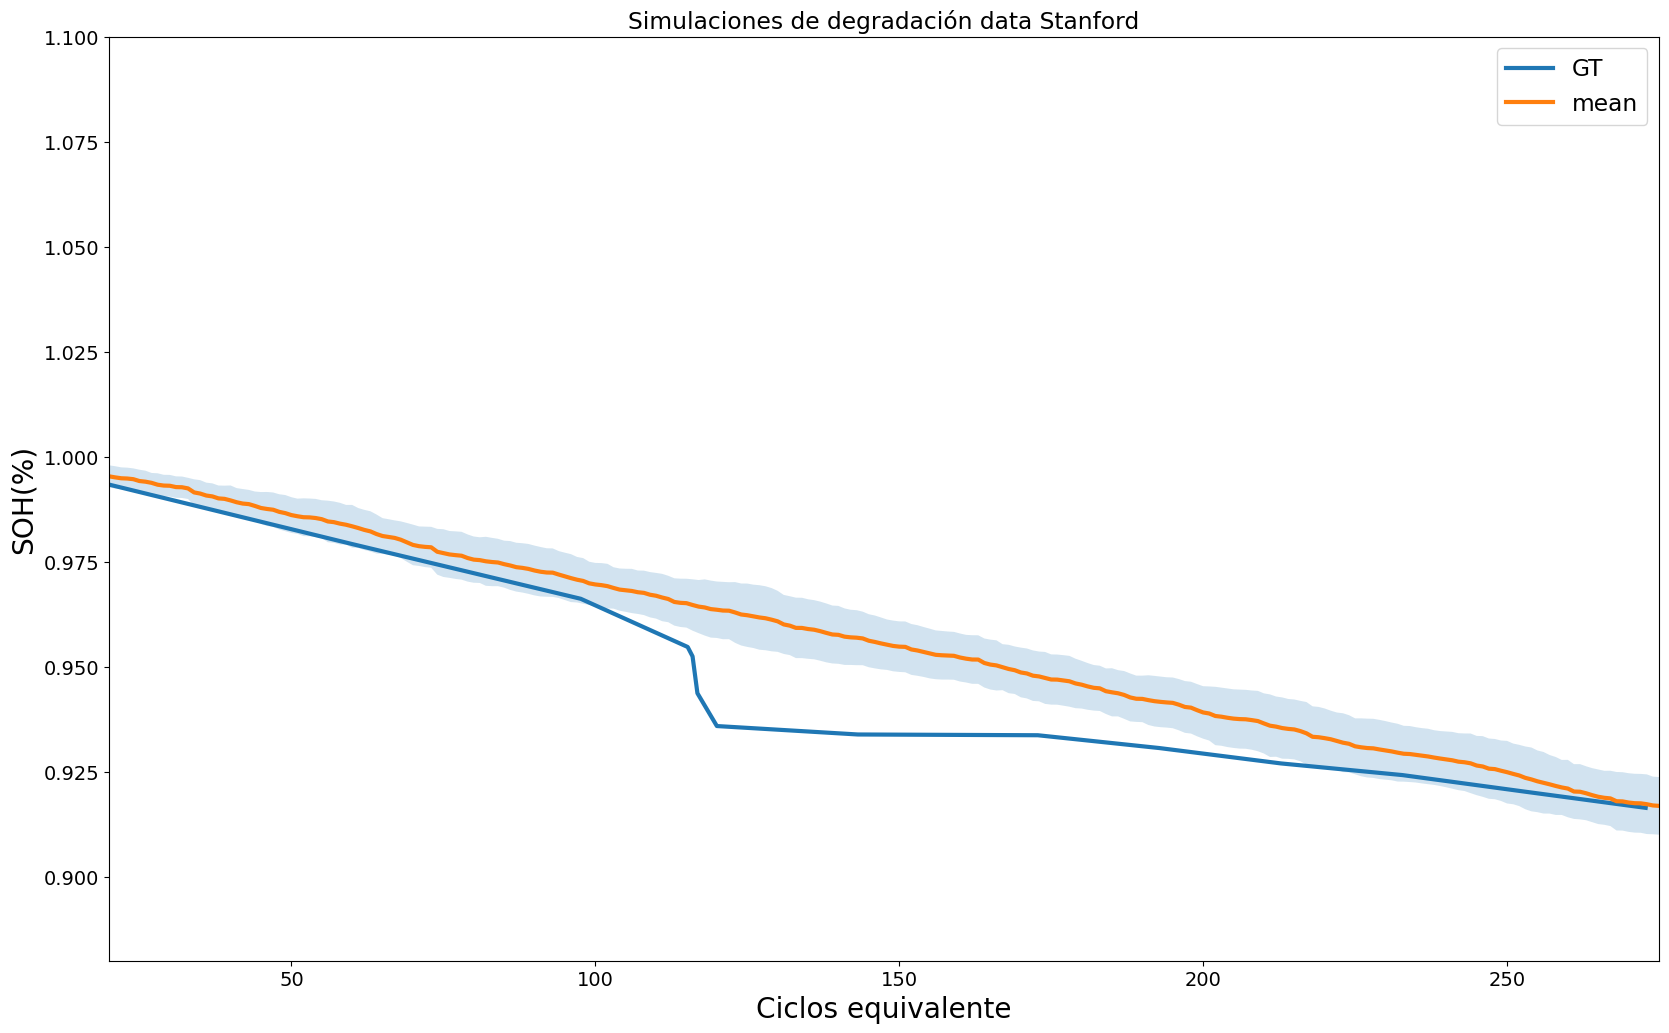

In [49]:
axis = np.arange(len(total_SOH['std']))

plt.figure(figsize=(20, 12))
# for column in total_SOH:
#     plt.plot(total_SOH[column],label=column)
plt.plot(w10_axis_val,SOH_gt_df['W10'],label="GT")
plt.plot(total_SOH['mean'],label='mean')

plt.fill_between(axis,total_SOH['mean']-total_SOH['std'],total_SOH['mean']+total_SOH['std'],alpha=0.2)
plt.ylim((0.88,1.1))
plt.xlim((20,275))

plt.title("Simulaciones de degradación data Stanford")
plt.xlabel("Ciclos equivalente")
plt.ylabel("SOH(%)")
plt.legend()
plt.show()

Anterior

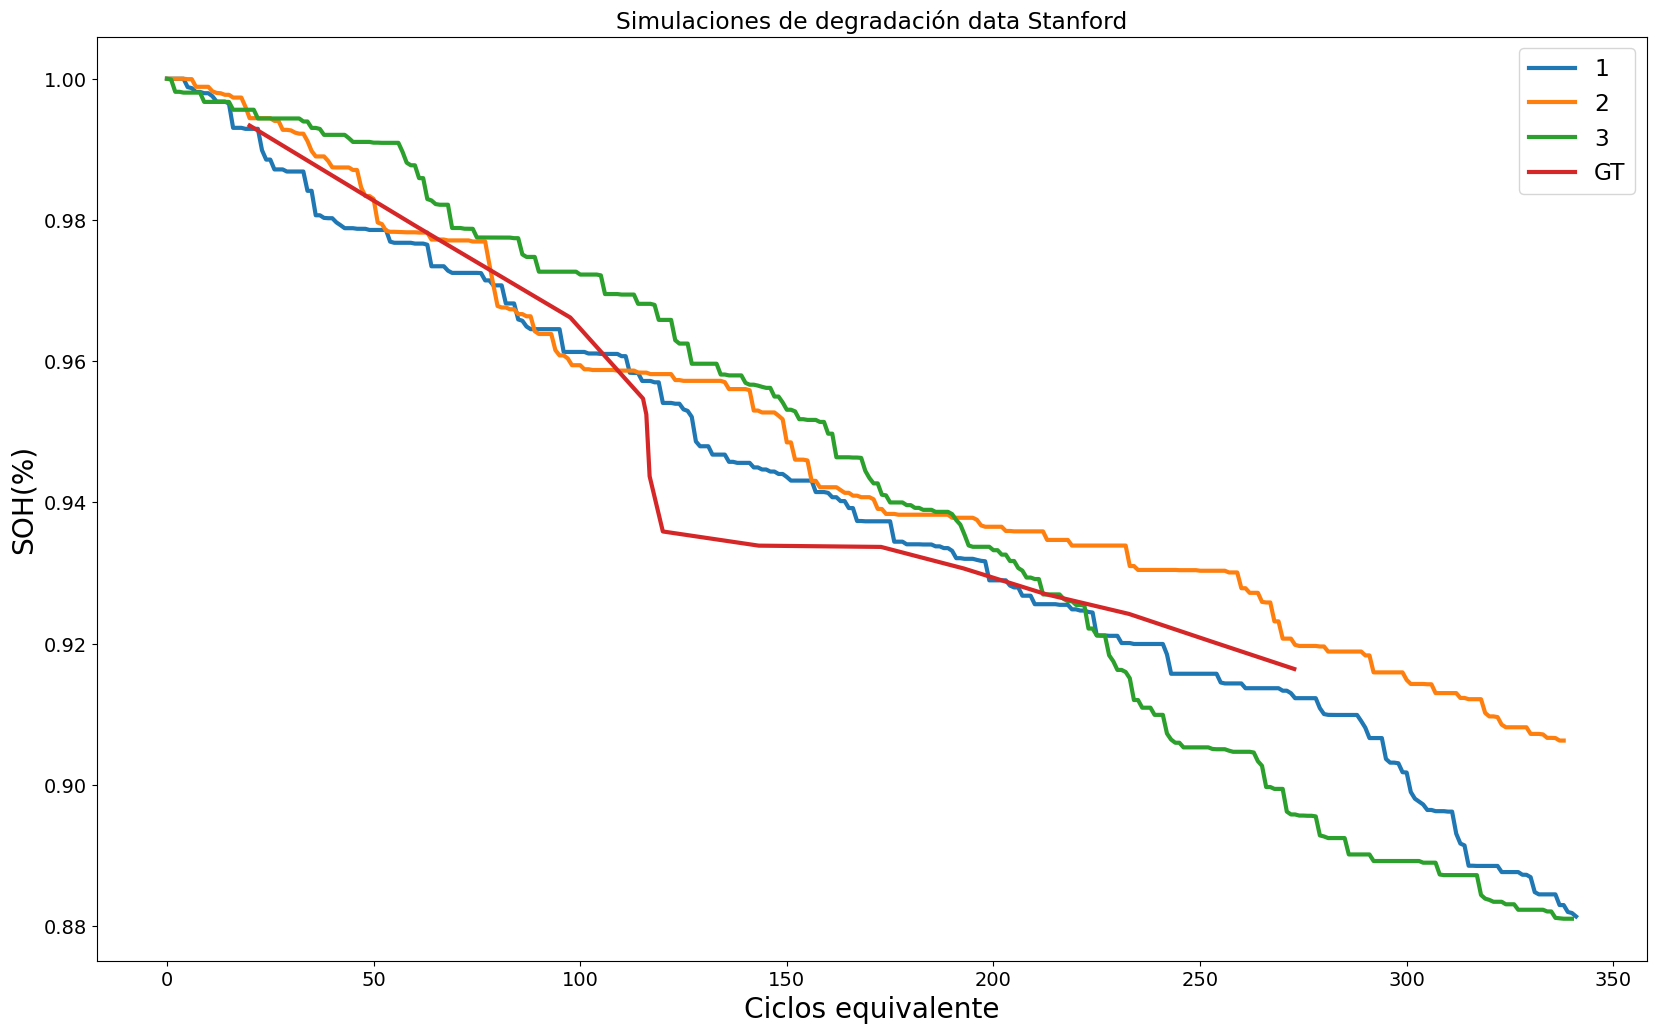

In [11]:
plt.figure(figsize=(20, 12))
for column in total_soh_values:
    plt.plot(total_soh_values[column],label=column)
plt.plot(w10_axis_val,SOH_gt_df['W10'],label="GT")

# plt.fill_between(axis,total_SOH['mean']-total_SOH['std'],total_SOH['mean']+total_SOH['std'],alpha=0.2)
# plt.ylim((0.88,1.1))

plt.title("Simulaciones de degradación data Stanford")
plt.xlabel("Ciclos equivalente")
plt.ylabel("SOH(%)")
plt.legend()
plt.show()

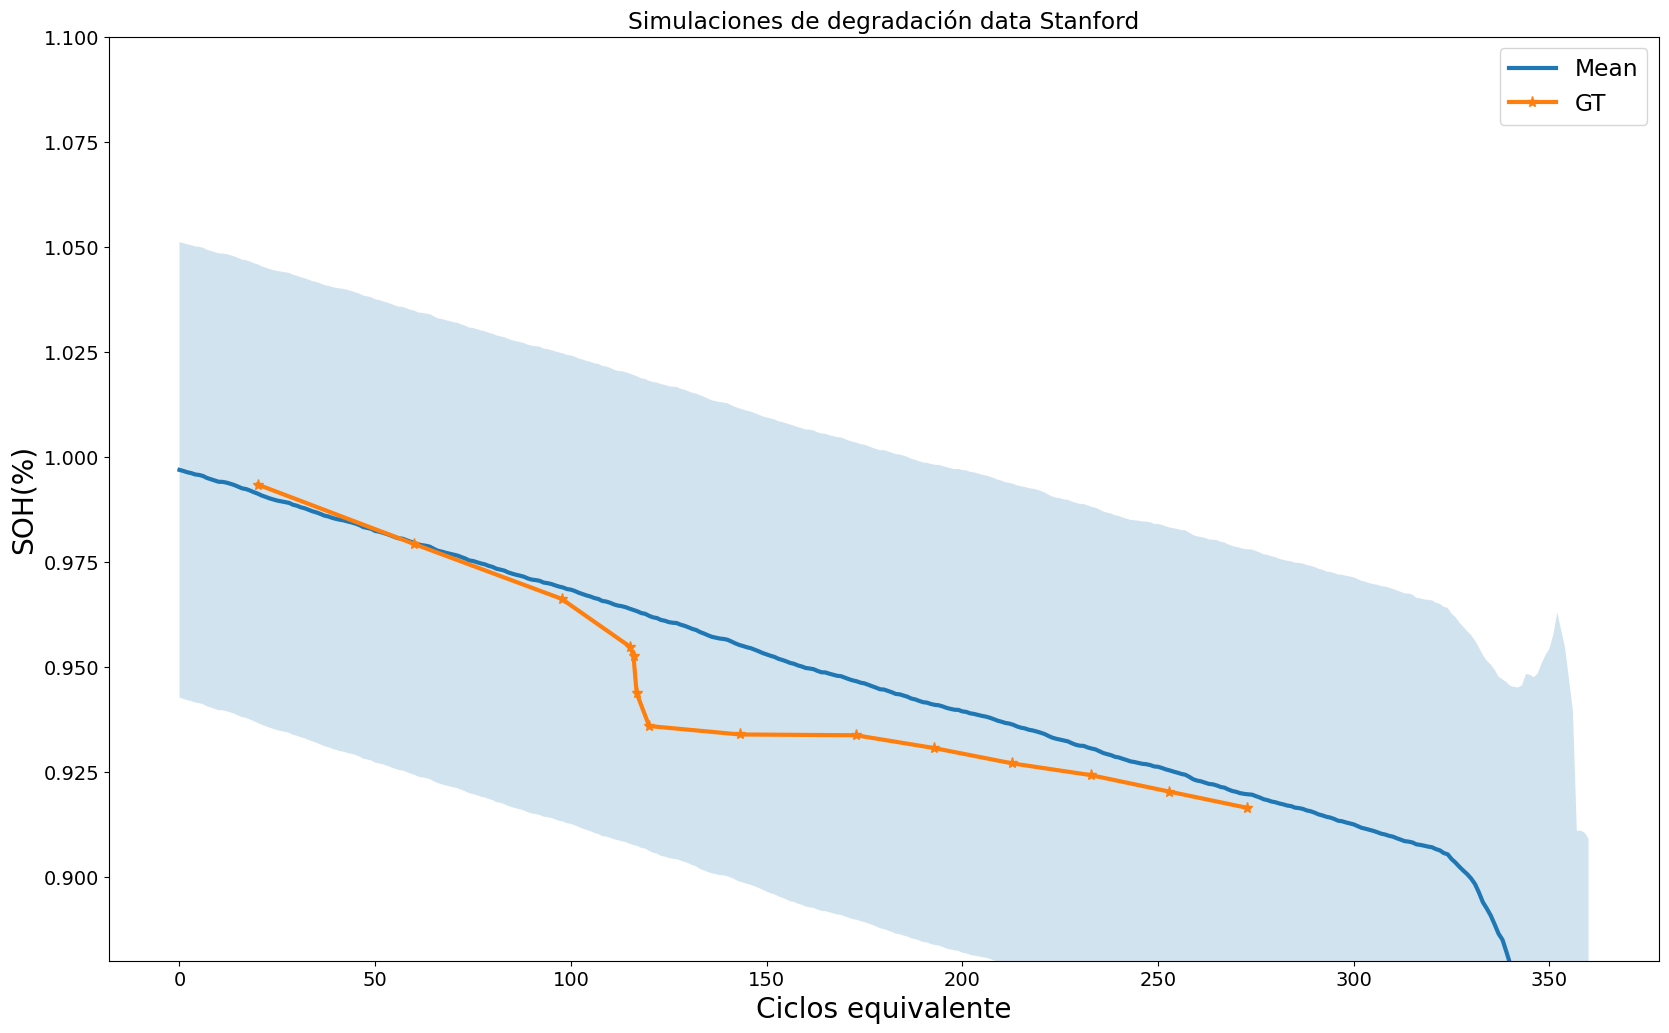

In [28]:
plt.figure(figsize=(20, 12))
plt.plot(total_SOH['mean'],label="Mean")
plt.plot(w10_axis_val,SOH_gt_df['W10'],label="GT",marker='*')

plt.fill_between(axis,total_SOH['mean']-total_SOH['std'],total_SOH['mean']+total_SOH['std'],alpha=0.2)
plt.ylim((0.88,1.1))

plt.title("Simulaciones de degradación data Stanford")
plt.xlabel("Ciclos equivalente")
plt.ylabel("SOH(%)")
plt.legend()
plt.show()